<a href="https://colab.research.google.com/github/XavierCarrera/platzi-master-ml-exercises/blob/main/AmazonProducts_RecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and Problem Definition

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [ ]:
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/db/reviews_Musical_Instruments.json', lines=True)
df.to_csv('reviews.csv', sep=',', index=False)

In [ ]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YS9MDZP93857,0006428320,John Taylor,"[0, 0]",The portfolio is fine except for the fact that...,3,Parts missing,1394496000,"03 11, 2014"
1,A3TS466QBAWB9D,0014072149,Silver Pencil,"[0, 0]",If you are a serious violin student on a budge...,5,"Perform it with a friend, today!",1370476800,"06 6, 2013"
2,A3BUDYITWUSIS7,0041291905,joyce gabriel cornett,"[0, 0]",This is and excellent edition and perfectly tr...,5,Vivalldi's Four Seasons,1381708800,"10 14, 2013"
3,A19K10Z0D2NTZK,0041913574,TexasCowboy,"[0, 0]",Perfect for someone who is an opera fan or a w...,5,Full score: voice and orchestra,1285200000,"09 23, 2010"
4,A14X336IB4JD89,0201891859,dfjm53,"[0, 1]",How many Nocturnes does it contain? All of the...,1,Unable to determine contents,1350432000,"10 17, 2012"
...,...,...,...,...,...,...,...,...,...
500171,A2XEVARMJP81E,B00LIR7QNS,Zoe,"[0, 0]","I'm very pleased with this recorder. Firstly, ...",5,"Excellent sound, very cheap, altos are rather ...",1405641600,"07 18, 2014"
500172,A3PAQGM6P87MXO,B00LJD5AUM,William Kilpatrick,"[0, 0]",i've been playing my m-4 for more years than i...,5,... years than i care to remember - it's a won...,1404518400,"07 5, 2014"
500173,A2KZX7A4XZ4T2W,B00LK7A9SK,Steve,"[1, 1]",This is an exceptionally nice sounding guitar....,5,great sound,1404518400,"07 5, 2014"
500174,AIDHT6KXOL64T,SMLRBIMX03,Leo Cameron,"[0, 0]",It was a perfect retrofit for my guitar. I lov...,5,A great choice for my guitar,1355788800,"12 18, 2012"


In [ ]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [ ]:
df.drop(["unixReviewTime", "reviewTime", "helpful"], axis=1, inplace=True)
df

,reviewerID,asin,reviewerName,reviewText,overall,summary
0,A1YS9MDZP93857,0006428320,John Taylor,The portfolio is fine except for the fact that...,3,Parts missing
1,A3TS466QBAWB9D,0014072149,Silver Pencil,If you are a serious violin student on a budge...,5,"Perform it with a friend, today!"
2,A3BUDYITWUSIS7,0041291905,joyce gabriel cornett,This is and excellent edition and perfectly tr...,5,Vivalldi's Four Seasons
3,A19K10Z0D2NTZK,0041913574,TexasCowboy,Perfect for someone who is an opera fan or a w...,5,Full score: voice and orchestra
4,A14X336IB4JD89,0201891859,dfjm53,How many Nocturnes does it contain? All of the...,1,Unable to determine contents
...,...,...,...,...,...,...
500171,A2XEVARMJP81E,B00LIR7QNS,Zoe,"I'm very pleased with this recorder. Firstly, ...",5,"Excellent sound, very cheap, altos are rather ..."
500172,A3PAQGM6P87MXO,B00LJD5AUM,William Kilpatrick,i've been playing my m-4 for more years than i...,5,... years than i care to remember - it's a won...
500173,A2KZX7A4XZ4T2W,B00LK7A9SK,Steve,This is an exceptionally nice sounding guitar....,5,great sound
500174,AIDHT6KXOL64T,SMLRBIMX03,Leo Cameron,It was a perfect retrofit for my guitar. I lov...,5,A great choice for my guitar


In [ ]:
df.isnull().sum().sum()

2586

In [ ]:
df.isnull().any()

reviewerID      False
asin            False
reviewerName     True
helpful         False
reviewText      False
overall         False
summary         False
dtype: bool

In [ ]:
df.drop(["reviewerName"], axis=1, inplace=True)
df

,reviewerID,asin,reviewText,overall,summary
0,A1YS9MDZP93857,0006428320,The portfolio is fine except for the fact that...,3,Parts missing
1,A3TS466QBAWB9D,0014072149,If you are a serious violin student on a budge...,5,"Perform it with a friend, today!"
2,A3BUDYITWUSIS7,0041291905,This is and excellent edition and perfectly tr...,5,Vivalldi's Four Seasons
3,A19K10Z0D2NTZK,0041913574,Perfect for someone who is an opera fan or a w...,5,Full score: voice and orchestra
4,A14X336IB4JD89,0201891859,How many Nocturnes does it contain? All of the...,1,Unable to determine contents
...,...,...,...,...,...
500171,A2XEVARMJP81E,B00LIR7QNS,"I'm very pleased with this recorder. Firstly, ...",5,"Excellent sound, very cheap, altos are rather ..."
500172,A3PAQGM6P87MXO,B00LJD5AUM,i've been playing my m-4 for more years than i...,5,... years than i care to remember - it's a won...
500173,A2KZX7A4XZ4T2W,B00LK7A9SK,This is an exceptionally nice sounding guitar....,5,great sound
500174,AIDHT6KXOL64T,SMLRBIMX03,It was a perfect retrofit for my guitar. I lov...,5,A great choice for my guitar


In [ ]:
df.dtypes

reviewerID    object
asin          object
helpful       object
reviewText    object
overall        int64
summary       object
dtype: object

In [ ]:
df.isnull().sum().sum()

0

# Exploratory Data Analysis

In [ ]:
users = len(np.unique(df.reviewerID	))
products = len(np.unique(df.asin))
print("Total users: " + str(users))
print("Total products: " + str(users))

Total users: 339231
Total products: 339231


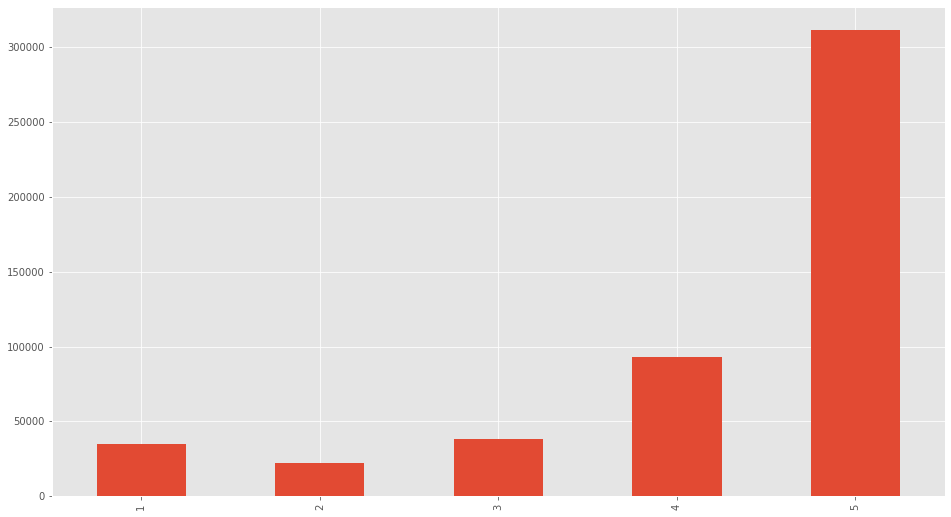

In [ ]:
df["overall"].value_counts().sort_index().plot(kind = "bar")